## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

greyscale

In [83]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [84]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [85]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [86]:
data_dir = Path('data')

In [87]:
RETRAIN = True
RESIZE_IMAGES = True

In [88]:
MODEL_NAME='cv_reflect_101'

In [89]:
NB_NUM='03_18'

In [90]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: cefad81a, DATE: 20191113


In [91]:
DATE = '20191112'
UID = '0dd880d4'

In [92]:
SUB_NUM='19'

In [93]:
img_size=256
border='reflect'

In [94]:
train_images=data_dir/f'train/rotated/clipped/{border}/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{border}/{img_size}'

In [95]:
test_names = get_image_files(test_images)

In [96]:
assert len(test_names)==7325

In [97]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [98]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [99]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [100]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [101]:
assert len(df_test)==7325

In [102]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [103]:
#xtra_tfms=[dihedral(p=0.5), zoom_crop(scale=(0.8,1.3), p=0.2)] 
xtra_tfms=[dihedral(p=0.7), rand_crop(p=0.4)] 

In [104]:
tfms = get_transforms(flip_vert=True, max_lighting=0.2, max_zoom=1.1, max_warp=0., xtra_tfms=xtra_tfms)
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [105]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [106]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [107]:
#to check what params object has
#dir(data)

In [108]:
data.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256

In [109]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

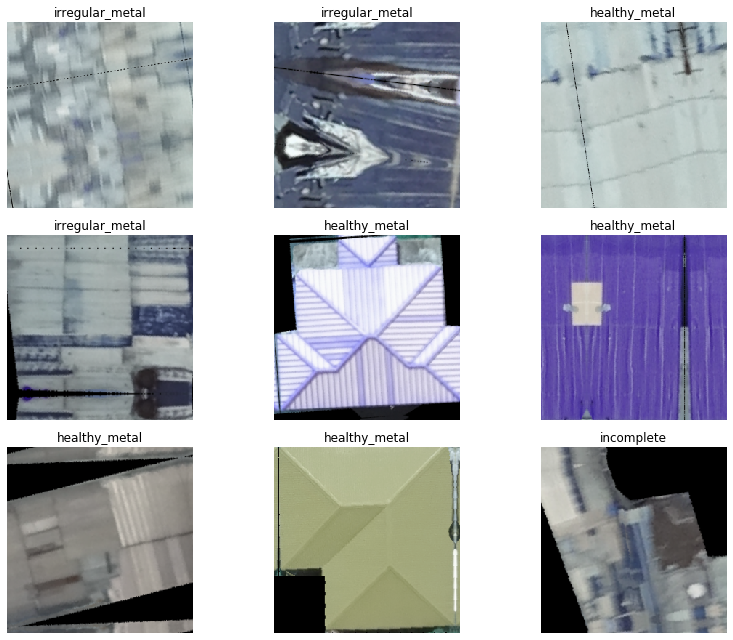

In [110]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [111]:
arch = models.resnet50
arch_name = 'rn50'

In [112]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True)

In [31]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### (Re)train model

In [32]:
if RETRAIN:
    learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


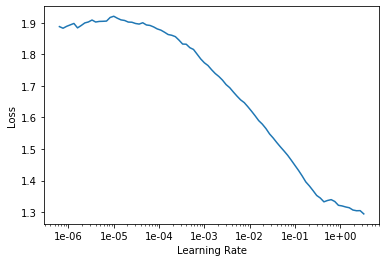

In [33]:
if RETRAIN:
    learn.recorder.plot()

Then we can fit the head of our network.

In [34]:
if RETRAIN:
    lr = 1e-1

In [35]:
if RETRAIN:
    learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.521528,0.781770,0.268293,01:15
1,0.468713,0.465175,0.159645,01:16
2,0.462581,0.432071,0.160310,01:17
3,0.402780,0.380070,0.130155,01:16
4,0.366551,0.406990,0.129047,01:16


<pre>
 epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.502964 	0.597735 	0.208426 	01:11
1 	0.486689 	0.498021 	0.175388 	01:11
2 	0.453843 	0.444588 	0.154767 	01:11
3 	0.415386 	0.416525 	0.147228 	01:11
4 	0.383324 	0.398478 	0.133925 	01:10
    </pre>

In [36]:
if RETRAIN:
    learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')
    #saves in parent of models directory
    #learn.export()

#### Load model

In [37]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 234),
 ('healthy_metal', 'irregular_metal', 94),
 ('incomplete', 'irregular_metal', 69),
 ('concrete_cement', 'healthy_metal', 34),
 ('other', 'healthy_metal', 34),
 ('healthy_metal', 'concrete_cement', 25),
 ('incomplete', 'concrete_cement', 23),
 ('incomplete', 'healthy_metal', 20),
 ('irregular_metal', 'concrete_cement', 15),
 ('concrete_cement', 'irregular_metal', 9),
 ('irregular_metal', 'incomplete', 9),
 ('concrete_cement', 'incomplete', 4),
 ('irregular_metal', 'other', 3),
 ('other', 'concrete_cement', 3),
 ('other', 'irregular_metal', 3),
 ('healthy_metal', 'other', 2)]

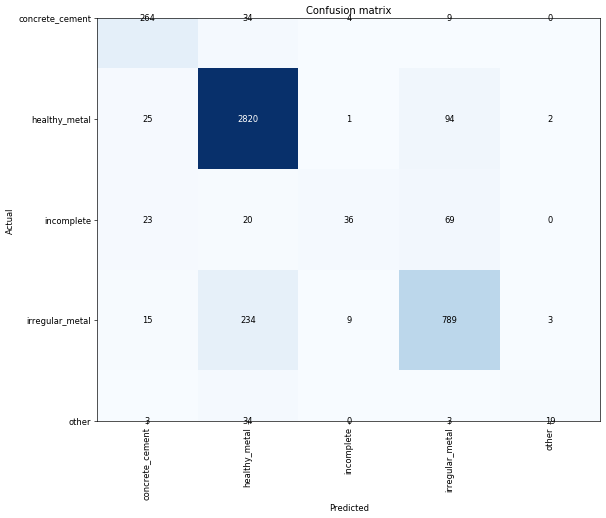

In [39]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [40]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


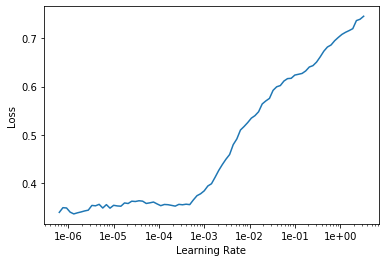

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.422356,0.438594,0.161419,01:39
1,0.430962,0.433294,0.154102,01:39
2,0.423770,0.391267,0.141907,01:39
3,0.386487,0.424472,0.130820,01:39
4,0.361849,0.357762,0.125499,01:39


<pre>
epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.438103 	0.431031 	0.157428 	01:37
1 	0.413694 	0.500094 	0.179823 	01:38
2 	0.405334 	0.394548 	0.143902 	01:35
3 	0.400567 	0.368481 	0.135920 	01:35
4 	0.352880 	0.357799 	0.128381 	01:35
    </pre>

In [43]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [44]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=

In [45]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.359453,0.408338,0.139246,01:39
1,0.379815,0.399289,0.141020,01:39
2,0.388502,0.377467,0.133038,01:39
3,0.364003,0.359576,0.129712,01:39
4,0.330204,0.351292,0.124834,01:39


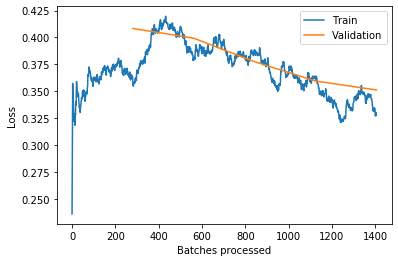

In [46]:
learn.recorder.plot_losses()

In [47]:
learn.save(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [48]:
learn.export(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [115]:
learn.load(f'stage-2-1-rn50-03_18-cv_reflect_101-20191112-0dd880d4')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=

In [116]:
learn.export()

### inference

In [117]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [118]:
len(test_dataset)

7325

In [123]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{border}/{img_size}', test=test_dataset)

In [124]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [125]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [126]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [127]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [128]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [129]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [130]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [131]:
labels = np.argmax(preds, 1)

In [132]:
len(preds)

7325

In [133]:
preds[0].tolist()

[0.03605922684073448,
 0.9557837247848511,
 0.001355881686322391,
 0.0055678002536296844,
 0.0012333740014582872]

In [134]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [135]:
len(labels)

7325

In [136]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [137]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [138]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [139]:
test_predictions[0]

'healthy_metal'

In [140]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [141]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/reflect/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/reflect/256/7a486800.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4c49fc.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a501f50.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4d27b4.tif')], dtype=object)

In [142]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [143]:
preds_list[0]

[0.03605922684073448,
 0.9557837247848511,
 0.001355881686322391,
 0.0055678002536296844,
 0.0012333740014582872]

In [144]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [145]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [146]:
df.head()

,id,pred
0,7a4d9168,"[0.03605922684073448, 0.9557837247848511, 0.00..."
1,7a4ae922,"[0.0036291698925197124, 0.8936655521392822, 0...."
2,7a48ca98,"[0.0025701632257550955, 0.1666972041130066, 0...."
3,7a49c614,"[0.0005623362376354635, 0.8945046067237854, 0...."
4,7a4dd4f2,"[0.0012448268244042993, 0.9586586952209473, 0...."


In [147]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [148]:
pred_df.insert(loc=0, column='id', value=ids)

In [149]:
pred_df.columns = cols

In [152]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.036059,0.955784,0.001356,0.005568,0.001233
1,7a4ae922,0.003629,0.893666,0.001688,0.099983,0.001034
2,7a48ca98,0.002570,0.166697,0.010366,0.819999,0.000368
3,7a49c614,0.000562,0.894505,0.000491,0.104184,0.000258
4,7a4dd4f2,0.001245,0.958659,0.000974,0.029561,0.009562


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [153]:
pred_ids=pred_df['id'].values.tolist()

In [154]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [155]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [156]:
baseline_ids=df_baseline['id'].values.tolist()

In [157]:
baseline_ids

['7a4d630a',
 '7a4bbbd6',
 '7a4ac744',
 '7a4881fa',
 '7a4aa4a8',
 '7a514434',
 '7a485f72',
 '7a4b8d32',
 '7a47eb3c',
 '7a4be3ae',
 '7a46a330',
 '7a481620',
 '7a49c678',
 '7a4ea044',
 '7a47aa1e',
 '7a51aa1e',
 '7a498be0',
 '7a4a2848',
 '7a4c4cd6',
 '7a465038',
 '7a4e94aa',
 '7a49f62a',
 '7a45b6f0',
 '7a50bb90',
 '7a4d38e4',
 '7a48a3a6',
 '7a4ebe9e',
 '7a48352e',
 '7a4bfaec',
 '7a51e060',
 '7a4c0f5a',
 '7a4b9976',
 '7a4b27d4',
 '7a51c698',
 '7a474bb4',
 '7a480054',
 '7a4a4044',
 '7a4c35ca',
 '7a4d3fd8',
 '7a4c1a68',
 '7a4eb1c4',
 '7a4a51ce',
 '7a4a14fc',
 '7a5015d2',
 '7a4ba95c',
 '7a5101ae',
 '7a4d0a22',
 '7a5134ee',
 '7a4a85c2',
 '7a514b14',
 '7a4d0a90',
 '7a485fd6',
 '7a4f668c',
 '7a44e752',
 '7a5162d4',
 '7a465894',
 '7a4c9a10',
 '7a485810',
 '7a4a9788',
 '7a503198',
 '7a4e206a',
 '7a4c15ea',
 '7a4f8536',
 '7a513df4',
 '7a4d7624',
 '7a4c9e8e',
 '7a4b2554',
 '7a502b12',
 '7a4c32e6',
 '7a4a8a2c',
 '7a467b76',
 '7a51b554',
 '7a4622e8',
 '7a4a599e',
 '7a4d17c4',
 '7a4fb740',
 '7a4ceed4',

In [158]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [159]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [160]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.036059,0.955784,0.001356,0.005568,0.001233,7a4d9168
1,7a4ae922,0.003629,0.893666,0.001688,0.099983,0.001034,7a4ae922
2,7a48ca98,0.002570,0.166697,0.010366,0.819999,0.000368,7a48ca98
3,7a49c614,0.000562,0.894505,0.000491,0.104184,0.000258,7a49c614
4,7a4dd4f2,0.001245,0.958659,0.000974,0.029561,0.009562,7a4dd4f2


In [161]:
pred_df=pred_df.sort_values('id_cat')

In [162]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
716,7a4d630a,0.008591,0.986976,0.000466,0.002885,0.001082,7a4d630a
764,7a4bbbd6,0.001976,0.944706,0.000626,0.052037,0.000655,7a4bbbd6
1841,7a4ac744,0.010692,0.834946,0.004627,0.148783,0.000951,7a4ac744
3363,7a4881fa,0.008177,0.187207,0.006996,0.796737,0.000884,7a4881fa
133,7a4aa4a8,0.011302,0.686686,0.005862,0.293829,0.002322,7a4aa4a8


In [163]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [164]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [ ]:
### Submission 2: 0.4461


In [ ]:
#arch_name = 'rn50'
#pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [ ]:
#pred_df.drop(columns=['id'],inplace=True)
#classes=pred_df.idxmax(axis=1)
#pd.value_counts(classes).plot(kind="bar")